# Model definition

## Settings

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import helpers.settings as sts
sts.print_settings(sts)

BEST_ESTIMATOR_FILENAME : best_estimator_0.0.1.pkl
DATASET_TRAIN_FILENAME : dataset_train.parquet
DATASET_VALIDATION_FILENAME : dataset_validation.parquet
ETL_VERSION : 0.0.1
MODEL_FILENAME : model.pkl
MODEL_VERSION : 0.0.1
PREPROCESSOR_FILENAME : preprocessor_0.0.1.pkl
TRAINED_BEST_ESTIMATOR_FILENAME : trained_best_estimator_0.0.1.pkl
color : <class 'helpers.settings.color'>
print_settings : <function print_settings at 0x7fe183ab3ee0>



## Imports

In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    plot_precision_recall_curve,
    precision_recall_curve,
    average_precision_score,
    plot_confusion_matrix,
)
import re
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt  
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

##  Load dataset

In [6]:
df_train = pd.read_parquet(f"data/{sts.DATASET_TRAIN_FILENAME}")

In [7]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

## Load preprocessor

In [8]:
with open(f"artifacts/{sts.PREPROCESSOR_FILENAME}","rb") as file:
    preprocessor = pickle.load(file)

## Model testing

### Deep Learning

In [9]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])
    return model

In [10]:
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=20, verbose=1)

In [11]:
clf_deep_learning = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(fill_value=0)),
        ("scaler", StandardScaler()),
        ("clf", model),
    ]
)

In [12]:
clf_deep_learning.fit(X_train, y_train)

Epoch 1/6
1550/1550 [==============================] - 1s 558us/step - loss: 0.1220 - auc: 0.0142
Epoch 2/6
1550/1550 [==============================] - 1s 656us/step - loss: 0.0688 - auc: 0.0262
Epoch 3/6
1550/1550 [==============================] - 1s 570us/step - loss: 0.0659 - auc: 0.0505
Epoch 4/6
1550/1550 [==============================] - 1s 547us/step - loss: 0.0640 - auc: 0.0710
Epoch 5/6
1550/1550 [==============================] - 1s 542us/step - loss: 0.0627 - auc: 0.0842
Epoch 6/6
1550/1550 [==============================] - 1s 541us/step - loss: 0.0618 - auc: 0.0934


Pipeline(steps=[('preprocessor',
                 ModifiedColumnTransformer(categorical_features=['CODE_GENDER',
                                                                 'FLAG_OWN_CAR',
                                                                 'FLAG_OWN_REALTY',
                                                                 'NAME_INCOME_TYPE',
                                                                 'NAME_EDUCATION_TYPE',
                                                                 'NAME_FAMILY_STATUS',
                                                                 'NAME_HOUSING_TYPE',
                                                                 'FLAG_MOBIL',
                                                                 'FLAG_WORK_PHONE',
                                                                 'FLAG_PHONE',
                                                                 'FLAG_EMAIL'],
                                           numeric_fea

In [13]:
y_proba = clf_deep_learning.predict_proba(X_train)[:,1]
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [14]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30584
           1       0.00      0.00      0.00       404

    accuracy                           0.99     30988
   macro avg       0.49      0.50      0.50     30988
weighted avg       0.97      0.99      0.98     30988



### Others

In [15]:
estimators = [
    {
        "clf": [XGBClassifier()],
    },
    {
        "clf": [LGBMClassifier()],
    },
    {
        "clf": [SVC()],
    },
    {
        "clf": [RandomForestClassifier()],
    },
    {
        "clf": [AdaBoostClassifier()],
    },
]

In [16]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier()),
    ],
)

In [17]:
gs = GridSearchCV(
    clf,
    estimators,
    scoring="average_precision",
    cv=5,
    n_jobs=1, 
    verbose=0,
)

In [18]:
gs.fit(X_train, y_train)

[21:05:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:05:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ModifiedColumnTransformer(categorical_features=['CODE_GENDER',
                                                                                        'FLAG_OWN_CAR',
                                                                                        'FLAG_OWN_REALTY',
                                                                                        'NAME_INCOME_TYPE',
                                                                                        'NAME_EDUCATION_TYPE',
                                                                                        'NAME_FAMILY_STATUS',
                                                                                        'NAME_HOUSING_TYPE',
                                                                                        'FLAG_MOBIL',
                                                                       

In [19]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.set_index(cv_results["param_clf"].apply(lambda x: f"{x}"[:7]), inplace=True)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
param_clf,,,,,,,,,,,,,,
XGBClas,0.866030,0.020059,0.024485,0.000577,"XGBClassifier(base_score=None, booster=None, c...","{'clf': XGBClassifier(base_score=None, booster...",0.873880,0.877768,0.817824,0.864884,0.899438,0.866759,0.026974,3
LGBMCla,0.285837,0.004124,0.027633,0.000950,LGBMClassifier(),{'clf': LGBMClassifier()},0.879147,0.901096,0.830885,0.897531,0.894564,0.880645,0.025983,2
SVC(),0.808972,0.058834,0.436364,0.023062,SVC(),{'clf': SVC()},0.016283,0.021956,0.011286,0.013137,0.015117,0.015556,0.003627,5
RandomF,1.317934,0.017149,0.070382,0.000435,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.892291,0.919193,0.843101,0.879864,0.918098,0.890509,0.028100,1
AdaBoos,0.633628,0.005375,0.042082,0.000305,AdaBoostClassifier(),{'clf': AdaBoostClassifier()},0.060729,0.041393,0.049174,0.054473,0.044713,0.050096,0.006896,4


<AxesSubplot:>

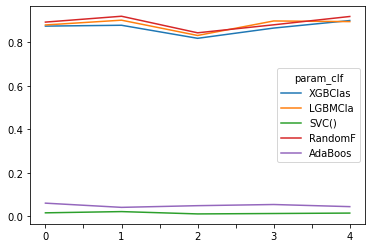

In [20]:
cv_results_splits = cv_results[[col for col in cv_results.columns if "split" in col]]
cv_results_splits.columns = [re.sub("[^0-9]", "", col) if "split" in col else col for col in cv_results_splits.columns]
cv_results_splits.T.plot()

In [21]:
y_proba = gs.best_estimator_.predict_proba(X_train)[:,1]
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [22]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30584
           1       0.96      0.96      0.96       404

    accuracy                           1.00     30988
   macro avg       0.98      0.98      0.98     30988
weighted avg       1.00      1.00      1.00     30988



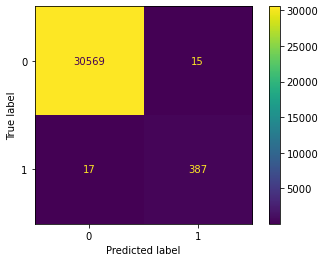

In [23]:
plot_confusion_matrix(gs.best_estimator_, X_train, y_train)

## Dump best estimator

In [24]:
with open(f"artifacts/{sts.BEST_ESTIMATOR_FILENAME}","wb") as file:
    pickle.dump(gs.best_estimator_, file)